# Imports and Setup

In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import japanize_matplotlib

In [2]:
%load_ext autoreload
%autoreload 1
%aimport prep

from prep import *
import pandas as pd
import statsmodels
from sklearn.metrics import mean_squared_error
from collections import namedtuple

In [3]:
df = pd.read_csv("../data/suumo.csv", low_memory=False, index_col=0)
df["apt_style"] = df["apt_style"].apply(apt_style_clean)

df["log_apt_rent"] = np.log(df["apt_rent"])


# Taking light look at data

In [4]:
moststations = df.groupby("station").mean().sort_values(by="apt_rent", ascending=False)

In [5]:
ook="東急大井町線/大岡山駅"
onarimon='都営三田線/御成門駅'

In [6]:
moststations.loc[onarimon]

b_age                 11.993377
b_no_floors           17.387417
apt_size              35.425762
apt_rent              17.925166
apt_admin_price    10189.503311
apt_floor              9.788079
apt_thanks_fee        19.095828
apt_deposit            9.988974
time_to_station        4.642384
log_apt_rent           2.740402
Name: 都営三田線/御成門駅, dtype: float64

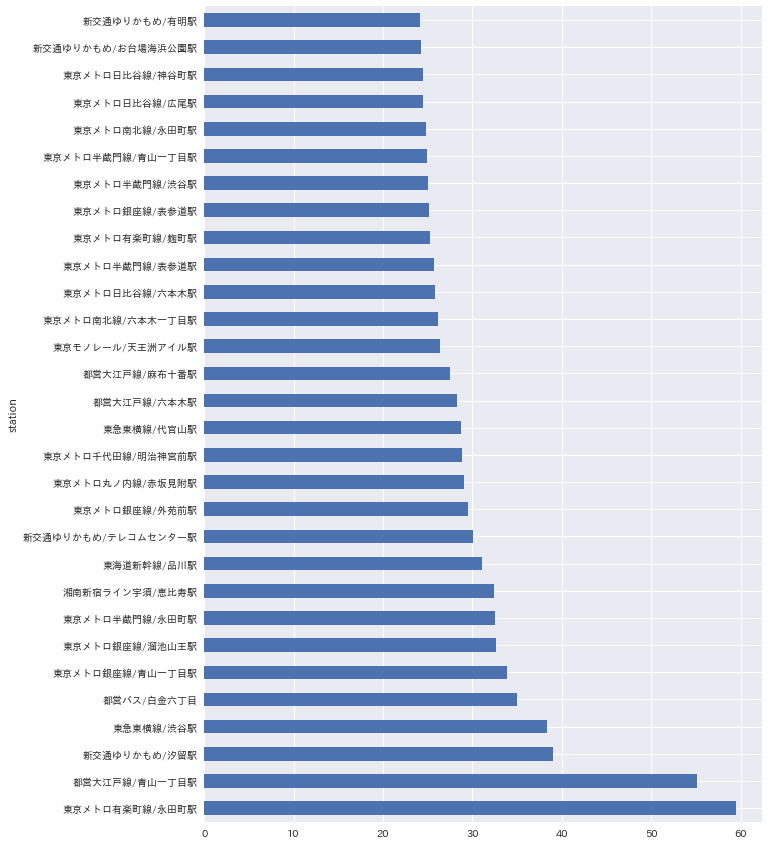

In [8]:
plt.figure(figsize=(10, 15))
moststations["apt_rent"].iloc[:30].plot.barh()

# Regression

In [9]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

##  Fit regression model 

Also declare two helper functions

In [10]:
def linear_model(formula, df, targ):
    results = smf.ols(formula.format(targ), data=df).fit()
    preds = results.predict(df)
    targs = df[targ]
    p = plot_regression_once(preds,targs,formula.format(targ))
    return results,p

def set_base(ser, base):
    cats = list(ser.unique())
    idx = cats.index(base)
    cats[idx] = cats[0]
    cats[0] = base
    return pd.Categorical(ser, categories=cats)

In [13]:
df["station"] = set_base(df["station"], "ＪＲ山手線/浜松町駅")
df["apt_style"] = set_base(df["apt_style"], "ワンルーム")
df["method"] = set_base(df["method"], "歩")

### Simple Regression of easiest variables on `rent`

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               apt_rent   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                 4.461e+04
Date:                Sat, 25 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:26:15   Log-Likelihood:            -4.0358e+05
No. Observations:              141394   AIC:                         8.072e+05
Df Residuals:                  141384   BIC:                         8.073e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.8127      0.035    -51.932      0.000      -1.881      -1.744
method[T.バス]                    -4.3947      0.321    -13.700      0.000      -5.023      -3.766
method[T.車]                     -0.5969      2.797     -0.213      0.831      -6.079       4.886
b_no_floors                      0.1134      0.003     36.999      0.000       0.107       0.119
apt_size                         0.3877      0.001    579.460      0.000       0.386       0.389
apt_admin_price               8.073e-05   2.33e-06     34.591      0.000    7.62e-05    8.53e-05
apt_floor                        0.1063      0.005     22.881      0.000       0.097       0.115
time_to_station                 -0.1090      0.004    -31.117      0.000      -0.116      -0.102
method[T.バス]:time_to_station     0.1178      0.034      3.493      0.000       0.052       0.184
method[T.車]:time_to_station     -0.1601      0.250     -0.641      0.521      -0.649       0.329
==============================================================================
Omnibus:                   199747.844   Durbin-Watson:                   1.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        261515271.924
Skew:                           7.805   Prob(JB):                         0.00
Kurtosis:                     213.108   Cond. No.                     2.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

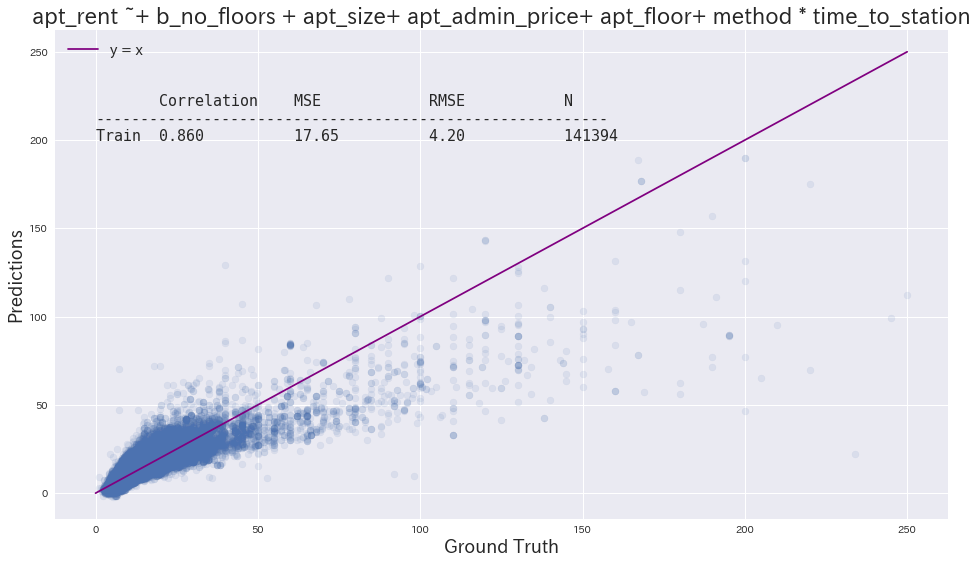

In [14]:
res,p = linear_model("{} ~"
                        "+ b_no_floors " 
                        "+ apt_size"
                        # "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "apt_rent")
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_apt_rent   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                 4.375e+04
Date:                Sat, 25 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:26:22   Log-Likelihood:                 11652.
No. Observations:              141394   AIC:                        -2.328e+04
Df Residuals:                  141384   BIC:                        -2.319e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.5829      0.002    855.007      0.000       1.579       1.587
method[T.バス]                    -0.2266      0.017    -13.316      0.000      -0.260      -0.193
method[T.車]                     -0.2471      0.148     -1.665      0.096      -0.538       0.044
b_no_floors                      0.0126      0.000     77.428      0.000       0.012       0.013
apt_size                         0.0185   3.55e-05    522.528      0.000       0.018       0.019
apt_admin_price               1.251e-05   1.24e-07    101.016      0.000    1.23e-05    1.27e-05
apt_floor                        0.0046      0.000     18.766      0.000       0.004       0.005
time_to_station                 -0.0083      0.000    -44.789      0.000      -0.009      -0.008
method[T.バス]:time_to_station     0.0075      0.002      4.192      0.000       0.004       0.011
method[T.車]:time_to_station      0.0027      0.013      0.205      0.838      -0.023       0.029
==============================================================================
Omnibus:                    69592.752   Durbin-Watson:                   0.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7000763.243
Skew:                          -1.436   Prob(JB):                         0.00
Kurtosis:                      37.352   Cond. No.                     2.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

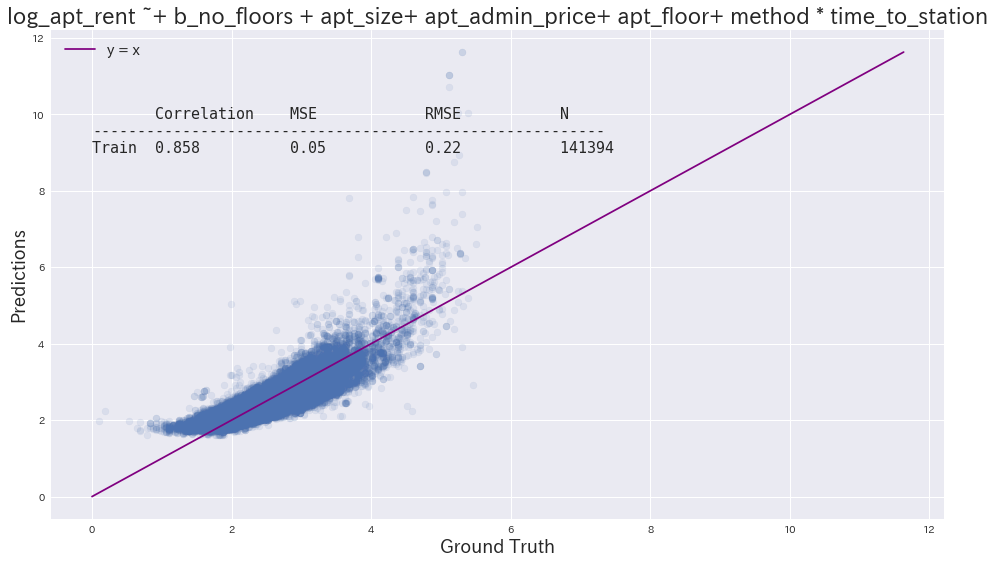

In [15]:
res,p = linear_model("{} ~"
                        "+ b_no_floors " 
                        "+ apt_size"
                        # "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "log_apt_rent")
res.summary()
            

### Regression on rent with `apt_style`

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               apt_rent   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Sat, 25 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:26:24   Log-Likelihood:            -3.9520e+05
No. Observations:              141394   AIC:                         7.905e+05
Df Residuals:                  141354   BIC:                         7.909e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.6884      0.042    -64.609      0.000      -2.770      -2.607
apt_style[T.1K]                 -0.8589      0.029    -29.869      0.000      -0.915      -0.803
apt_style[T.2DK]                -6.6653      0.064   -104.309      0.000      -6.791      -6.540
apt_style[T.2LDK]               -4.2044      0.073    -57.617      0.000      -4.347      -4.061
apt_style[T.5以上]               -25.9629      0.398    -65.211      0.000     -26.743     -25.183
apt_style[T.1SLDK]              -5.2744      0.171    -30.862      0.000      -5.609      -4.939
apt_style[T.1LDK]               -2.7213      0.045    -60.461      0.000      -2.810      -2.633
apt_style[T.2SLDK]              -5.5027      0.225    -24.411      0.000      -5.945      -5.061
apt_style[T.3LDK]               -7.0819      0.120    -59.151      0.000      -7.317      -6.847
apt_style[T.1DK]                -1.9975      0.045    -44.092      0.000      -2.086      -1.909
apt_style[T.2K]                 -4.0492      0.075    -54.055      0.000      -4.196      -3.902
apt_style[T.3DK]               -11.3838      0.163    -70.031      0.000     -11.702     -11.065
apt_style[T.4LDK]              -13.1740      0.284    -46.307      0.000     -13.732     -12.616
apt_style[T.3K]                 -8.9046      0.325    -27.399      0.000      -9.542      -8.268
apt_style[T.1SK]                -2.0076      0.298     -6.736      0.000      -2.592      -1.423
apt_style[T.4K]                -13.6519      0.713    -19.134      0.000     -15.050     -12.254
apt_style[T.3SDK]               -7.7719      0.866     -8.973      0.000      -9.470      -6.074
apt_style[T.2SDK]               -9.8939      0.532    -18.607      0.000     -10.936      -8.852
apt_style[T.4DK]               -13.5563      0.638    -21.244      0.000     -14.807     -12.306
apt_style[T.4SLDK]             -10.1657      0.576    -17.640      0.000     -11.295      -9.036
apt_style[T.3LK]                -9.5818      3.960     -2.419      0.016     -17.344      -1.820
apt_style[T.1SDK]               -3.4269      0.377     -9.081      0.000      -4.167      -2.687
apt_style[T.3SLDK]              -6.4675      0.362    -17.878      0.000      -7.177      -5.758
apt_style[T.2SK]                -5.9290      1.059     -5.599      0.000      -8.004      -3.854
apt_style[T.1SLK]               -7.2618      2.801     -2.593      0.010     -12.751      -1.772
apt_style[T.3SK]               -15.0177      1.772     -8.474      0.000     -18.491     -11.544
apt_style[T.4SDK]              -28.5076      1.983    -14.374      0.000     -32.395     -24.620
apt_style[T.1LK]                -2.6017      0.990     -2.627      0.009      -4.543      -0.660
apt_style[T.2LK]                -4.8560      3.960     -1.226      0.220    

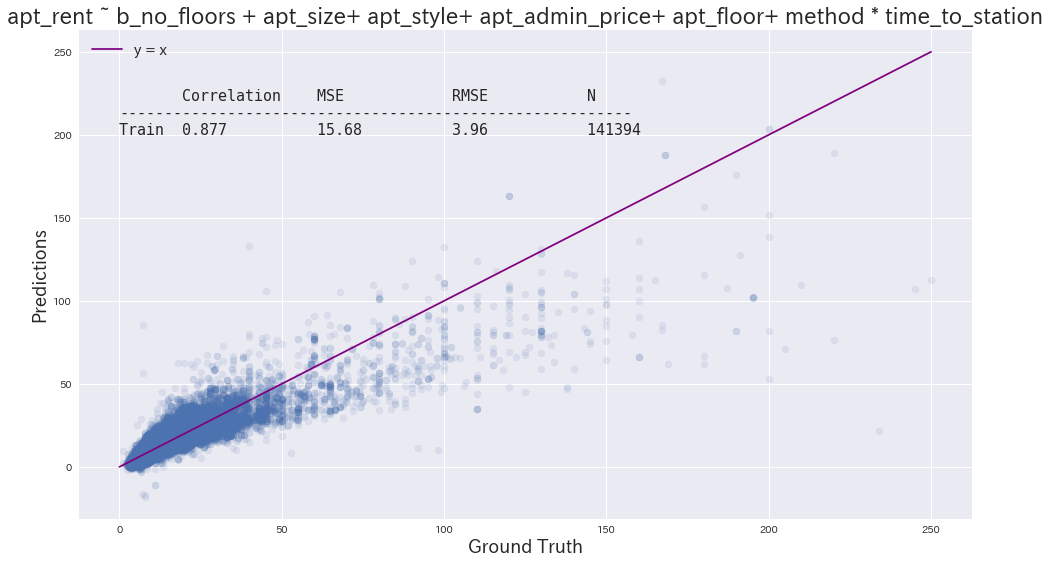

In [16]:
res,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "apt_rent")
res.summary()

### Regression on log rent with style

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_apt_rent   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 1.315e+04
Date:                Sat, 25 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:26:27   Log-Likelihood:                 25883.
No. Observations:              141394   AIC:                        -5.169e+04
Df Residuals:                  141354   BIC:                        -5.129e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.5841      0.002    748.070      0.000       1.580       1.588
apt_style[T.1K]                  0.0259      0.001     17.684      0.000       0.023       0.029
apt_style[T.2DK]                -0.0044      0.003     -1.350      0.177      -0.011       0.002
apt_style[T.2LDK]                0.2276      0.004     61.297      0.000       0.220       0.235
apt_style[T.5以上]                -1.1178      0.020    -55.170      0.000      -1.158      -1.078
apt_style[T.1SLDK]               0.1960      0.009     22.536      0.000       0.179       0.213
apt_style[T.1LDK]                0.2526      0.002    110.295      0.000       0.248       0.257
apt_style[T.2SLDK]               0.1430      0.011     12.464      0.000       0.120       0.165
apt_style[T.3LDK]                0.0803      0.006     13.181      0.000       0.068       0.092
apt_style[T.1DK]                 0.0929      0.002     40.303      0.000       0.088       0.097
apt_style[T.2K]                 -0.0278      0.004     -7.281      0.000      -0.035      -0.020
apt_style[T.3DK]                -0.0671      0.008     -8.107      0.000      -0.083      -0.051
apt_style[T.4LDK]               -0.4364      0.014    -30.144      0.000      -0.465      -0.408
apt_style[T.3K]                 -0.0318      0.017     -1.923      0.055      -0.064       0.001
apt_style[T.1SK]                 0.1010      0.015      6.662      0.000       0.071       0.131
apt_style[T.4K]                 -0.1182      0.036     -3.255      0.001      -0.189      -0.047
apt_style[T.3SDK]                0.1336      0.044      3.031      0.002       0.047       0.220
apt_style[T.2SDK]                0.0817      0.027      3.020      0.003       0.029       0.135
apt_style[T.4DK]                -0.0175      0.032     -0.540      0.589      -0.081       0.046
apt_style[T.4SLDK]              -0.6052      0.029    -20.636      0.000      -0.663      -0.548
apt_style[T.3LK]                 0.0812      0.202      0.403      0.687      -0.314       0.476
apt_style[T.1SDK]                0.2009      0.019     10.461      0.000       0.163       0.239
apt_style[T.3SLDK]              -0.0476      0.018     -2.583      0.010      -0.084      -0.011
apt_style[T.2SK]                 0.0207      0.054      0.384      0.701      -0.085       0.126
apt_style[T.1SLK]               -0.0005      0.143     -0.004      0.997      -0.280       0.279
apt_style[T.3SK]                -0.0807      0.090     -0.895      0.371      -0.257       0.096
apt_style[T.4SDK]               -0.4135      0.101     -4.097      0.000      -0.611      -0.216
apt_style[T.1LK]                 0.1935      0.050      3.840      0.000       0.095       0.292
apt_style[T.2LK]                 0.2508      0.202      1.244      0.213    

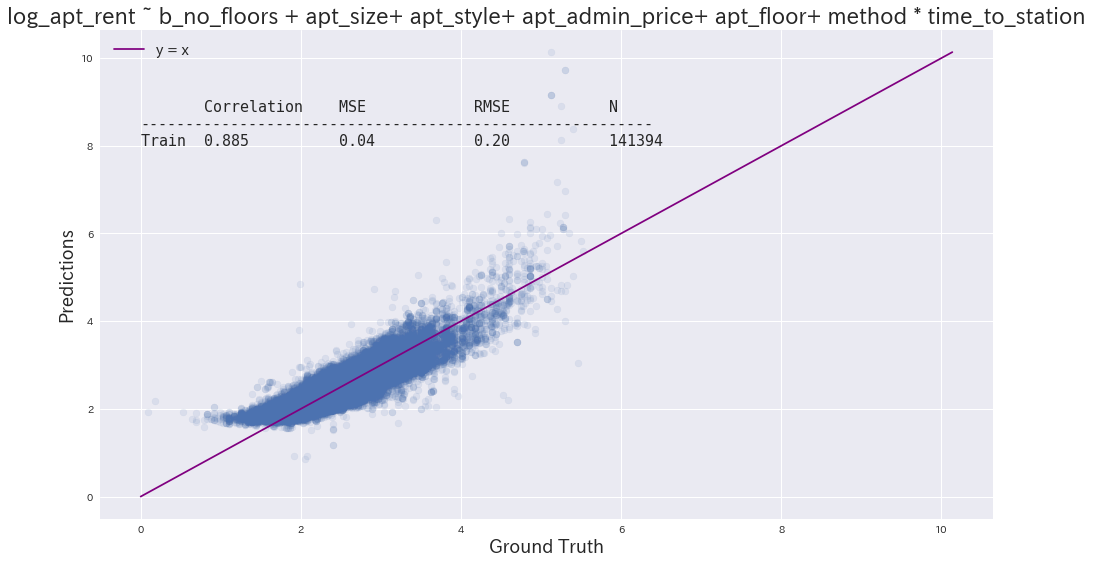

In [17]:
res,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        # "+ station"
                        ,df, "log_apt_rent")
res.summary()

### Regression on apt_rent using all variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               apt_rent   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     834.5
Date:                Sat, 25 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:26:44   Log-Likelihood:            -3.8102e+05
No. Observations:              141394   AIC:                         7.635e+05
Df Residuals:                  140671   BIC:                         7.706e+05
Df Model:                         722                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.5910      0.299     -5.320      0.000      -2.177      -1.005
apt_style[T.1K]                      -0.4530      0.027    -17.049      0.000      -0.505      -0.401
apt_style[T.2DK]                     -5.2304      0.059    -88.368      0.000      -5.346      -5.114
apt_style[T.2LDK]                    -3.2548      0.067    -48.442      0.000      -3.387      -3.123
apt_style[T.5以上]                    -20.9566      0.365    -57.478      0.000     -21.671     -20.242
apt_style[T.1SLDK]                   -3.9592      0.156    -25.314      0.000      -4.266      -3.653
apt_style[T.1LDK]                    -2.2410      0.042    -53.997      0.000      -2.322      -2.160
apt_style[T.2SLDK]                   -3.8399      0.206    -18.675      0.000      -4.243      -3.437
apt_style[T.3LDK]                    -5.0736      0.110    -45.930      0.000      -5.290      -4.857
apt_style[T.1DK]                     -1.4629      0.042    -34.960      0.000      -1.545      -1.381
apt_style[T.2K]                      -3.0465      0.069    -44.199      0.000      -3.182      -2.911
apt_style[T.3DK]                     -9.2060      0.150    -61.391      0.000      -9.500      -8.912
apt_style[T.4LDK]                    -9.5465      0.261    -36.614      0.000     -10.058      -9.035
apt_style[T.3K]                      -7.3042      0.296    -24.663      0.000      -7.885      -6.724
apt_style[T.1SK]                     -1.6812      0.276     -6.100      0.000      -2.221      -1.141
apt_style[T.4K]                     -11.4185      0.649    -17.585      0.000     -12.691     -10.146
apt_style[T.3SDK]                    -6.4850      0.788     -8.227      0.000      -8.030      -4.940
apt_style[T.2SDK]                    -8.0204      0.484    -16.582      0.000      -8.968      -7.072
apt_style[T.4DK]                    -12.0900      0.580    -20.831      0.000     -13.228     -10.952
apt_style[T.4SLDK]                   -6.0066      0.525    -11.440      0.000      -7.036      -4.978
apt_style[T.3LK]                     -7.7526      3.597     -2.155      0.031     -14.802      -0.703
apt_style[T.1SDK]                    -2.7320      0.344     -7.949      0.000      -3.406      -2.058
apt_style[T.3SLDK]                   -4.2716      0.331    -12.900      0.000      -4.921      -3.623
apt_style[T.2SK]                     -5.5661      0.961     -5.791      0.000      -7.450      -3.682
apt_style[T.1SLK]                    -5.3210      2.546     -2.090      0.037     -10.310      -0.332
apt_style[T.3SK]                    -12.7679      1.613     -7.917      0.000     -15.929      -9.607
apt_style[T.4SDK]                   -24.7287      1.802    -13.722      0.000     -28.261     -21.197
apt_style[T.1LK]       

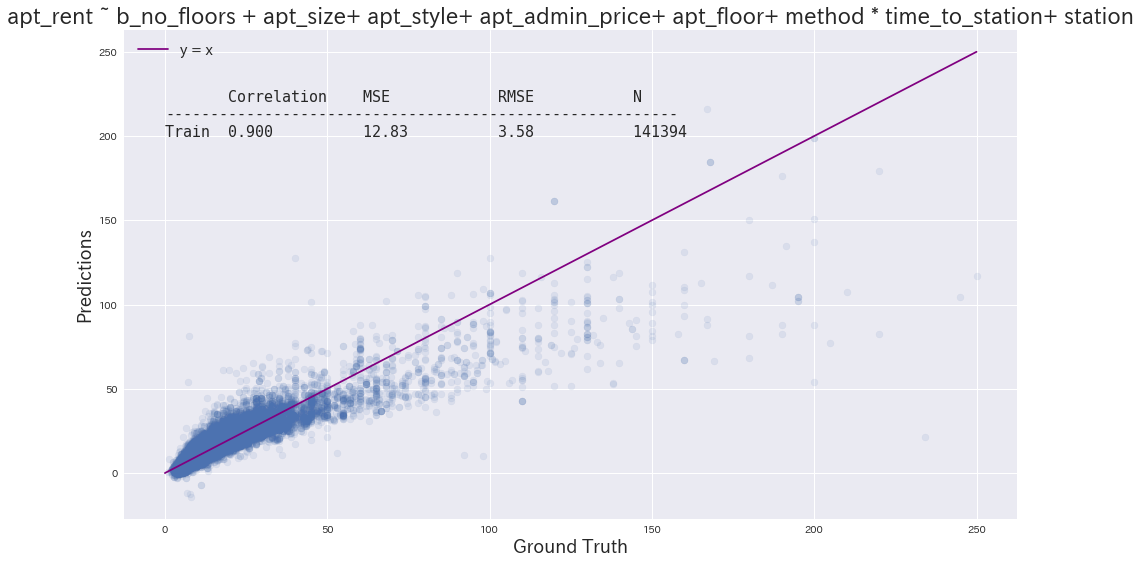

In [18]:
res,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        "+ station"
                        ,df, "apt_rent")
res.summary()

### Regerssion on all variables using `log_rent`

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_apt_rent   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1169.
Date:                Sat, 25 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:27:00   Log-Likelihood:                 55146.
No. Observations:              141394   AIC:                        -1.088e+05
Df Residuals:                  140671   BIC:                        -1.017e+05
Df Model:                         722                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             1.7030      0.014    124.489      0.000       1.676       1.730
apt_style[T.1K]                       0.0513      0.001     42.204      0.000       0.049       0.054
apt_style[T.2DK]                      0.0971      0.003     35.855      0.000       0.092       0.102
apt_style[T.2LDK]                     0.2879      0.003     93.685      0.000       0.282       0.294
apt_style[T.5以上]                     -0.7986      0.017    -47.885      0.000      -0.831      -0.766
apt_style[T.1SLDK]                    0.2735      0.007     38.236      0.000       0.260       0.288
apt_style[T.1LDK]                     0.2787      0.002    146.830      0.000       0.275       0.282
apt_style[T.2SLDK]                    0.2458      0.009     26.132      0.000       0.227       0.264
apt_style[T.3LDK]                     0.2047      0.005     40.514      0.000       0.195       0.215
apt_style[T.1DK]                      0.1251      0.002     65.335      0.000       0.121       0.129
apt_style[T.2K]                       0.0468      0.003     14.853      0.000       0.041       0.053
apt_style[T.3DK]                      0.0867      0.007     12.636      0.000       0.073       0.100
apt_style[T.4LDK]                    -0.1996      0.012    -16.732      0.000      -0.223      -0.176
apt_style[T.3K]                       0.0852      0.014      6.287      0.000       0.059       0.112
apt_style[T.1SK]                      0.1343      0.013     10.656      0.000       0.110       0.159
apt_style[T.4K]                       0.0439      0.030      1.479      0.139      -0.014       0.102
apt_style[T.3SDK]                     0.2100      0.036      5.823      0.000       0.139       0.281
apt_style[T.2SDK]                     0.1985      0.022      8.973      0.000       0.155       0.242
apt_style[T.4DK]                      0.0744      0.027      2.802      0.005       0.022       0.126
apt_style[T.4SLDK]                   -0.3363      0.024    -14.003      0.000      -0.383      -0.289
apt_style[T.3LK]                      0.1796      0.165      1.092      0.275      -0.143       0.502
apt_style[T.1SDK]                     0.2355      0.016     14.978      0.000       0.205       0.266
apt_style[T.3SLDK]                    0.0880      0.015      5.808      0.000       0.058       0.118
apt_style[T.2SK]                      0.0306      0.044      0.696      0.486      -0.056       0.117
apt_style[T.1SLK]                     0.0054      0.116      0.047      0.963      -0.223       0.234
apt_style[T.3SK]                      0.0636      0.074      0.862      0.389      -0.081       0.208
apt_style[T.4SDK]                    -0.1954      0.082     -2.371      0.018      -0.357      -0.034
apt_style[T.1LK]       

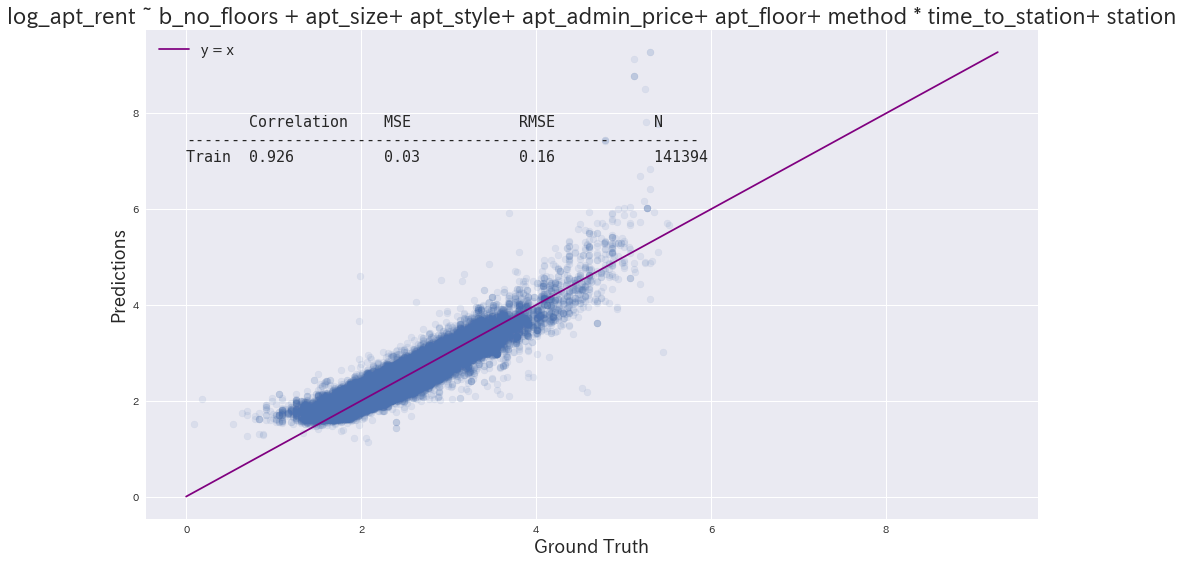

In [ ]:
res,p = linear_model("{} ~ b_no_floors " 
                         "+ apt_size"
                        "+ apt_style"
                        "+ apt_admin_price"
                        "+ apt_floor"
                        "+ method * time_to_station"
                        "+ station"
                        ,df, "log_apt_rent")
res.summary()

We can see that it is mostly overvaluing the most places